# Modern Portfolio Theory

We want to use modern portfolio theory (MPT) for identification of optimal portfolios consisting of various crypto assets.

## Import Data

In [1]:
# import basic modules
import numpy as np
import pandas as pd
import datetime as dt
import warnings

# filter warnings
warnings.filterwarnings("ignore")

In [2]:
# import data from yahoo finance using the pandas data-reader
from pandas_datareader import data as pdr
def getData(assets, start, end, feature):
    data = pdr.get_data_yahoo(assets, start = start, end = end)
    data = data[feature] # select adjusted closing price
    return data

In [3]:
# select assets to use
data_list = ["BTC-USD", "ETH-USD", "ADA-USD", "LINK-USD", "BNB-USD"]

In [4]:
# set start and end date for data collection
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*3)

In [5]:
# create dataframe
df = getData(data_list, start = startDate, end = endDate, feature = "Adj Close")
print(df)

Symbols          BTC-USD      ETH-USD   ADA-USD   LINK-USD     BNB-USD
Date                                                                  
2018-03-25   8209.400391   489.950989  0.167806   0.371496   12.061400
2018-03-26   7833.040039   450.115997  0.154926   0.342625   11.508300
2018-03-27   7954.479980   446.278992  0.160058   0.351367   11.640400
2018-03-28   7165.700195   385.967987  0.146882   0.280161   10.196100
2018-03-29   6890.520020   394.644989  0.147209   0.287494   10.350400
...                  ...          ...       ...        ...         ...
2021-03-21  57523.421875  1788.217041  1.189140  29.272839  264.886169
2021-03-22  54529.144531  1691.333984  1.109874  27.398113  255.900192
2021-03-23  54738.945312  1678.650146  1.121552  26.915058  255.689667
2021-03-24  52774.265625  1593.413452  1.075002  25.053885  249.851379
2021-03-25  51511.117188  1598.821289  1.109406  25.694105  232.496902

[1092 rows x 5 columns]


## Data Exploration

Comparing and visualizing distributions of asset returns and checking for skewness and kurtosis.

Skewness: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^3}{s^3}$, Kurtosis: $\frac{1}{n}\sum^{n}_{t=1}\frac{(r_{t}-\bar{r})^4}{s^4}$

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

# use higher resolution for plots
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# scipy for computing skewness and kurtosis
import scipy.stats as stats

In [7]:
#create function for easy plotting
def multiPlot(asset):
    # distribution plot using simple returns
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    sns.histplot(asset.pct_change().iloc[1:], ax = ax[0], bins = 30, color = "lightcyan", stat = "density")
    sns.kdeplot(asset.pct_change().iloc[1:], ax = ax[0], color = "blue", linestyle = "--", label = "Kernel Density")
    ax[0].set_xlim(-0.3, 0.3)
    ax[0].set_xlabel("Simple Returns")
    ax[0].set_title("Histogram of simple returns")
    
    # compute normal distribution for comparison with asset distributions
    mean, std = stats.norm.fit(asset.pct_change().iloc[1:])
    x = np.linspace(-0.3, 0.3, 300)
    p = stats.norm.pdf(x, mean, std)
    ax[0].plot(x, p, "r", linewidth = 2, label = "Normal")
    ax[0].legend()

    # probability plot
    stats.probplot(asset.pct_change().iloc[1:], dist = "norm", rvalue = True, fit = True, plot = plt)
    plt.xlabel("Normal Distribution")
    plt.ylabel("Sample Distribution")

Recall that a normal distribution in the form of $f(x)=\frac{1}{\sigma \sqrt{2\pi}}\exp\left[ -\frac{(x-\mu)^2}{2\sigma^2} \right]$ has a skewness of 0 and a kurtosis of 3.

### Bitcoin (BTC)
Bitcoin is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries. Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. Bitcoins are created as a reward for a process known as mining.

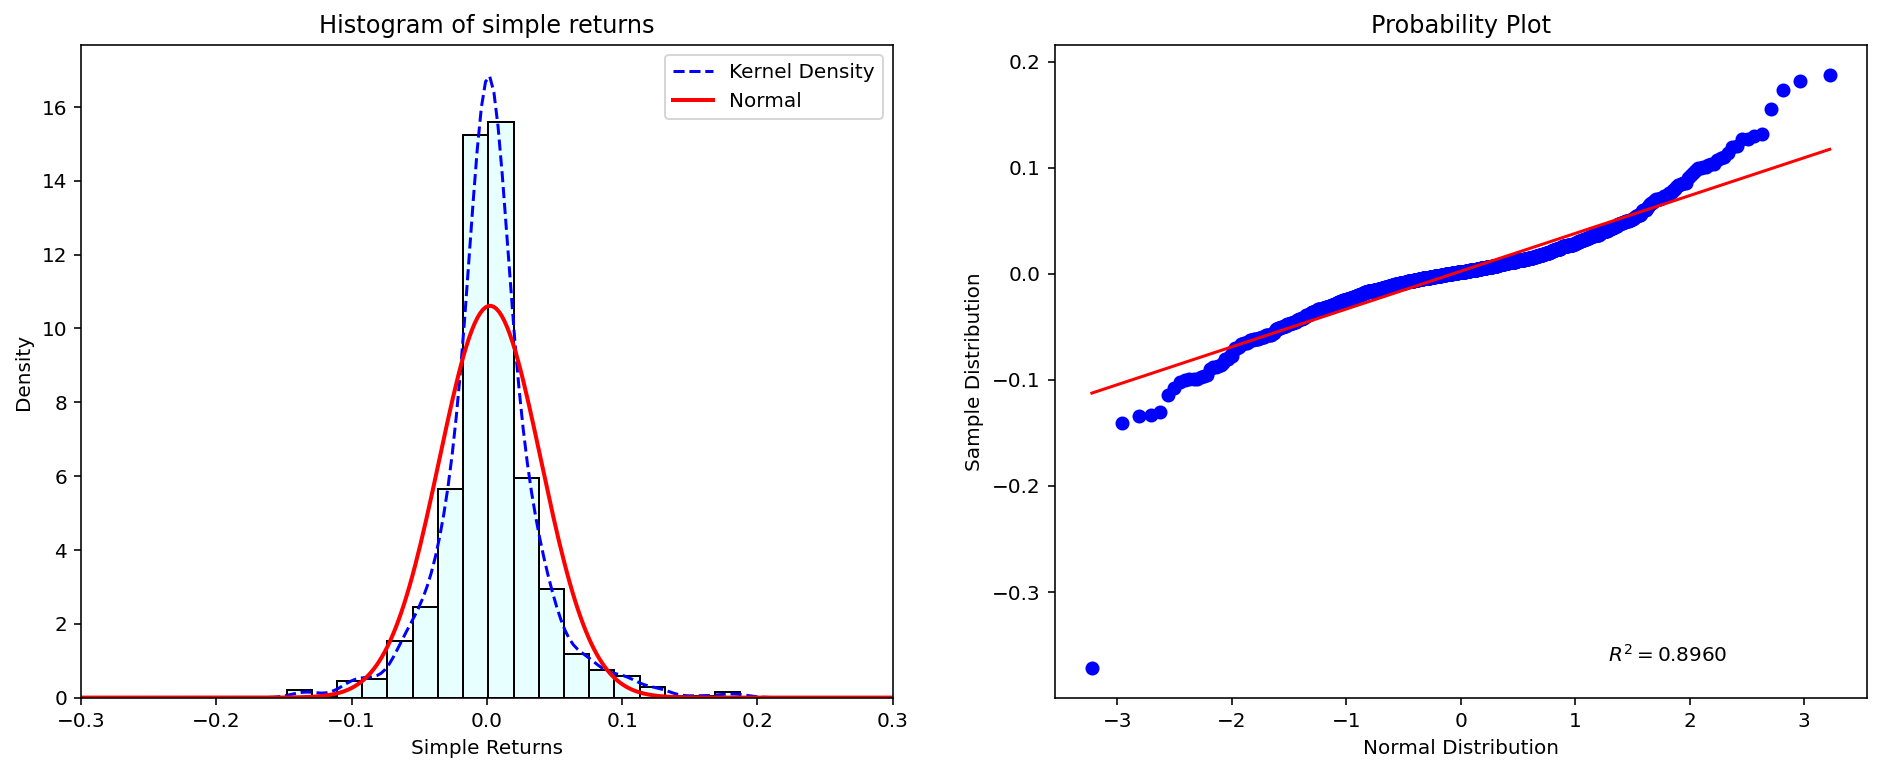

In [8]:
multiPlot(df["BTC-USD"])

In [9]:
print("BTC distribution skewness: " + str(stats.skew(df["BTC-USD"].pct_change().iloc[1:])))
print("BTC distribution kurtosis: " + str(stats.kurtosis(df["BTC-USD"].pct_change().iloc[1:])))

BTC distribution skewness: -0.5051148407890521
BTC distribution kurtosis: 11.457318951211473


### Ethereum (ETH)
Ethereum is a decentralized, open-source blockchain with smart contract functionality. Ether (ETH) is the native cryptocurrency of the platform. It is the second-largest cryptocurrency by market capitalization, after Bitcoin. Ethereum is the most actively used blockchain.

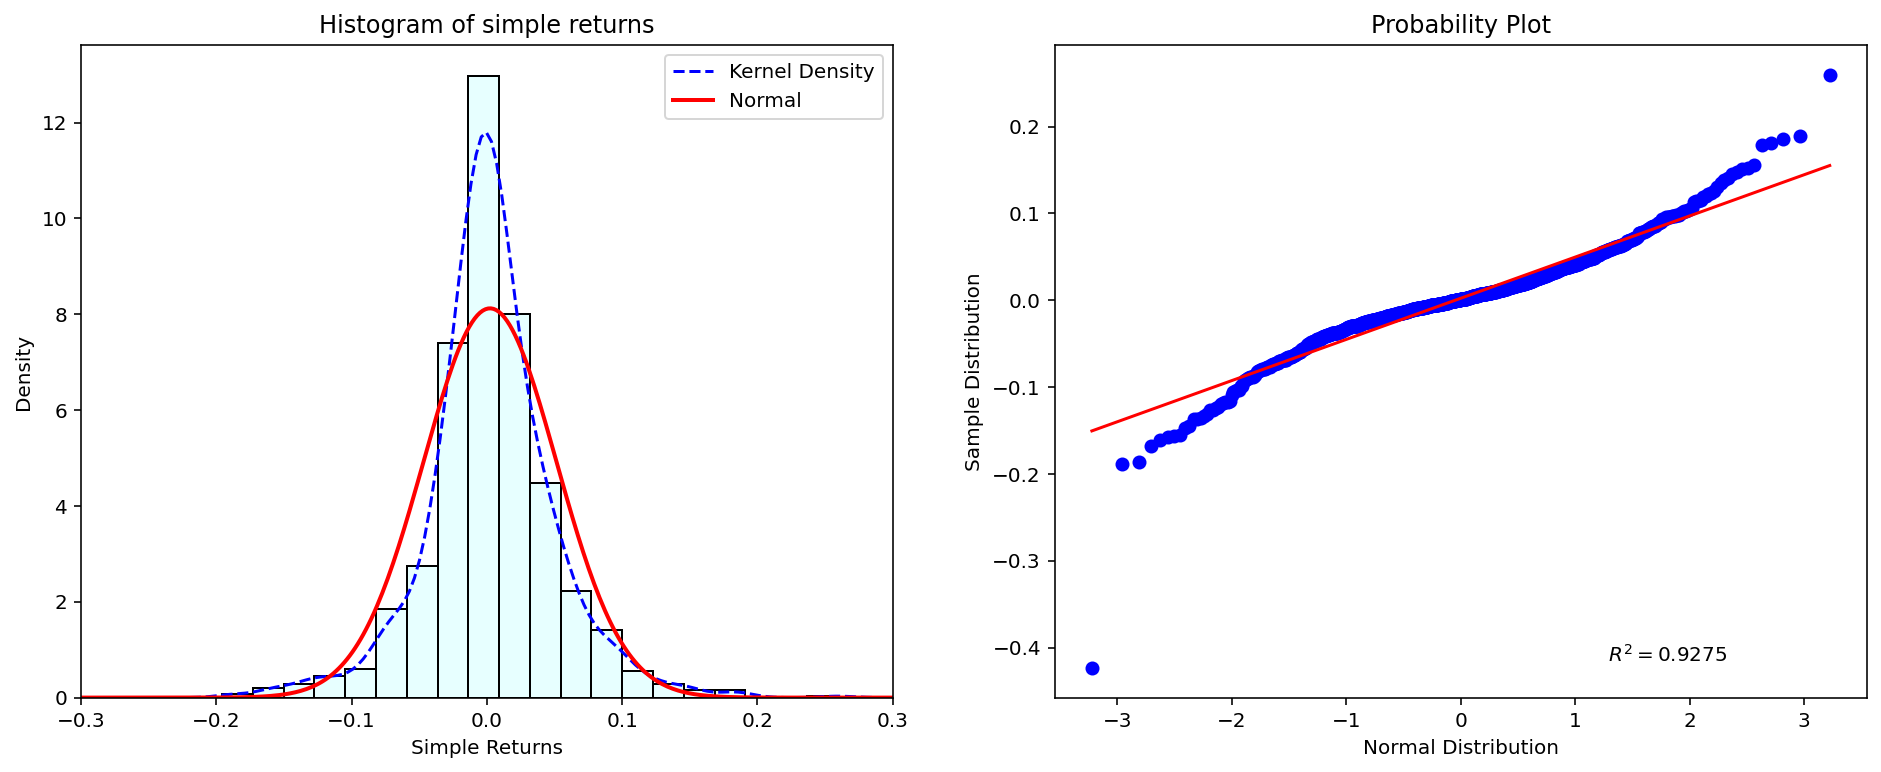

In [10]:
multiPlot(df["ETH-USD"])

In [11]:
print("ETH distribution skewness: " + str(stats.skew(df["ETH-USD"].pct_change().iloc[1:])))
print("ETH distribution kurtosis: " + str(stats.kurtosis(df["ETH-USD"].pct_change().iloc[1:])))

ETH distribution skewness: -0.47694243042348194
ETH distribution kurtosis: 7.230215115268036


### Cardano (ADA)
Cardano is a cryptocurrency network and open source project that aims to run a public blockchain platform for smart contracts. Cardano's internal cryptocurrency is called ADA. The development of the project is overseen and supervised by the Cardano Foundation based in Zug, Switzerland. Cardano uses Ouroboros proof of stake technology. In contrast, Bitcoin uses the proof of work system; the first blockchain entry and the longest blockchain (blockchain with the most computing power) is used to determine the honest blockchain. Cardano uses only the first blockchain entry, whereafter the honest chain is proven locally without the need of a trusted party.

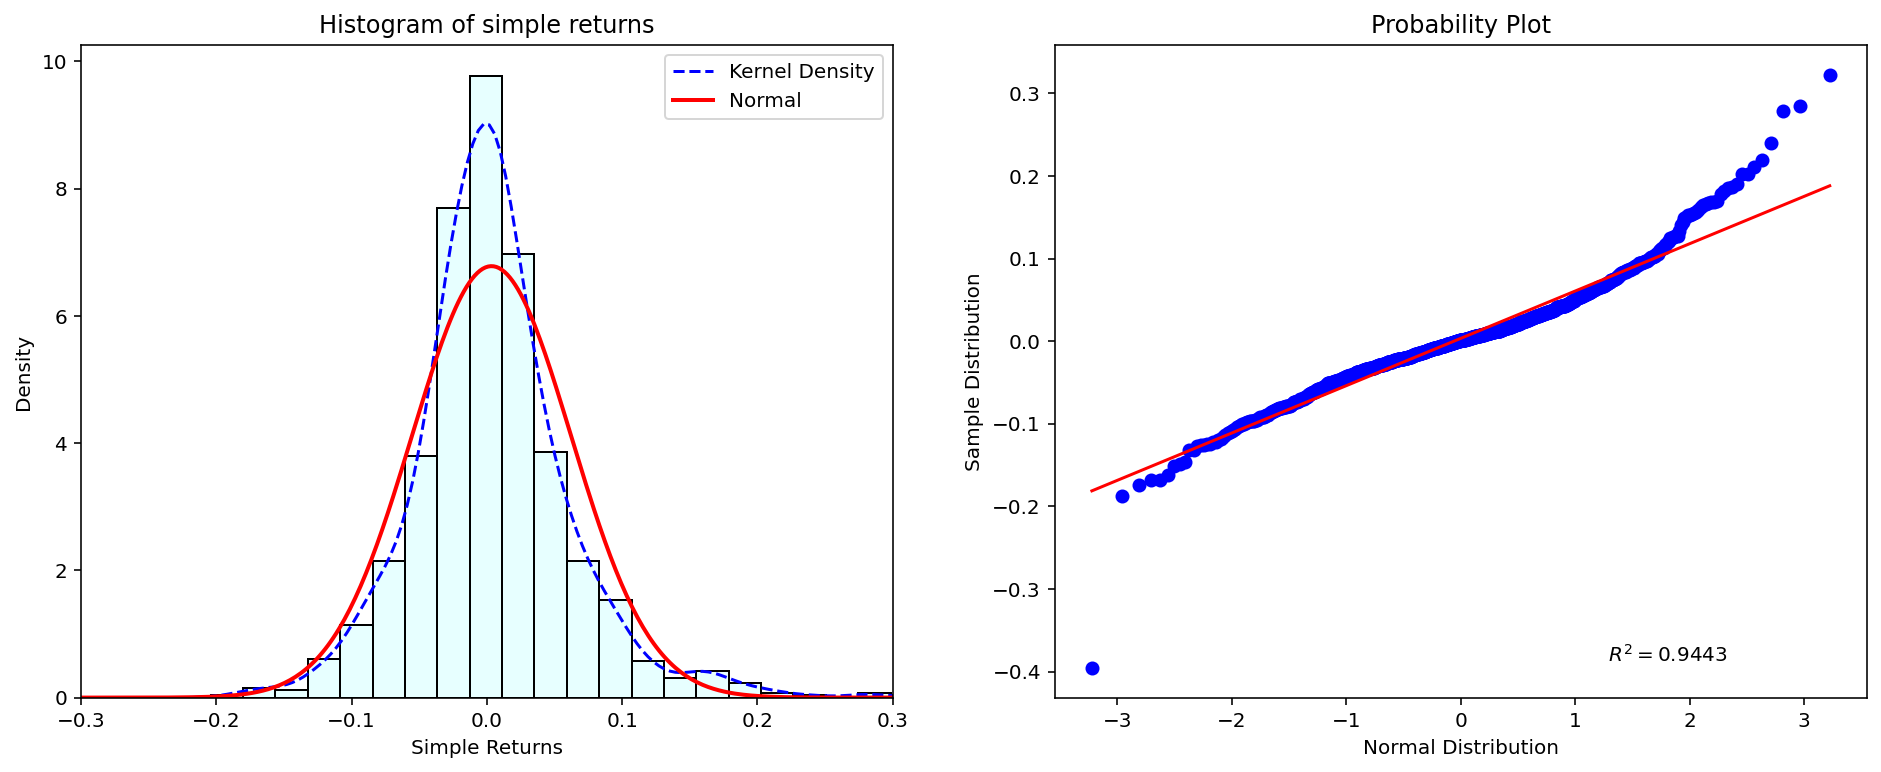

In [12]:
multiPlot(df["ADA-USD"])

In [13]:
print("ADA distribution skewness: " + str(stats.skew(df["ADA-USD"].pct_change().iloc[1:])))
print("ADA distribution kurtosis: " + str(stats.kurtosis(df["ADA-USD"].pct_change().iloc[1:])))

ADA distribution skewness: 0.41952646790126524
ADA distribution kurtosis: 4.384689351563356


### Chainlink (LINK)
Chainlink’s technology claims to solve one of the biggest challenges for the practical implementation of smart contracts – connecting blockchains to real world data – such as price feeds or delivery confirmations – through so-called oracles blockchain connectivity.

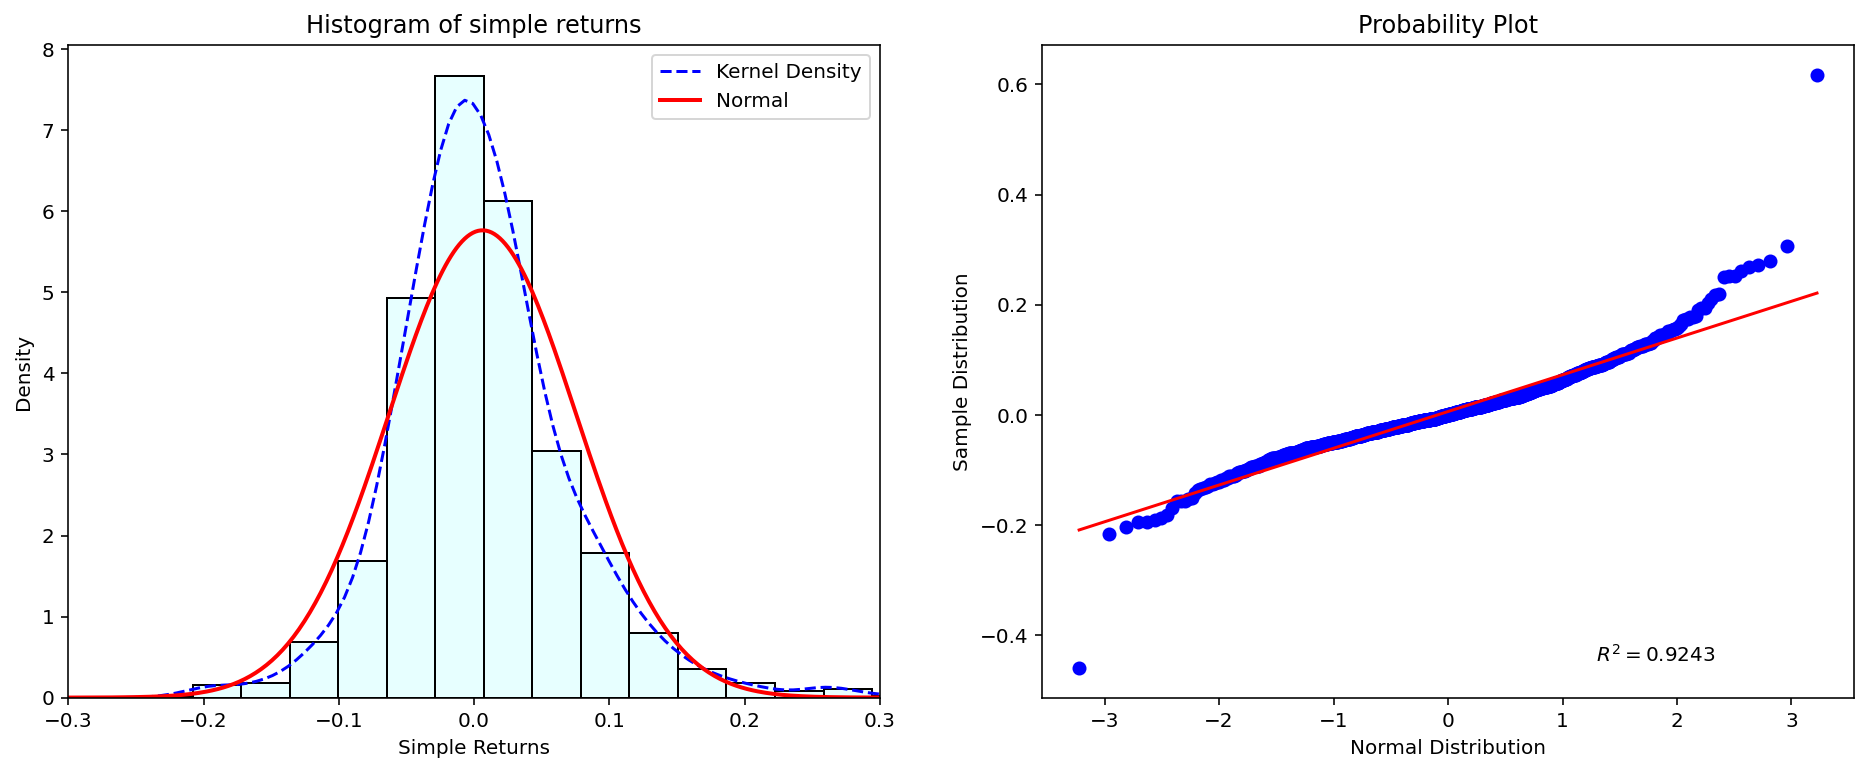

In [14]:
multiPlot(df["LINK-USD"])

In [15]:
print("LINK distribution skewness: " + str(stats.skew(df["LINK-USD"].pct_change().iloc[1:])))
print("LINK distribution kurtosis: " + str(stats.kurtosis(df["LINK-USD"].pct_change().iloc[1:])))

LINK distribution skewness: 0.8461310302604873
LINK distribution kurtosis: 8.446466174764101


### Binance Coin (BNB)
BNB powers the Binance Ecosystem. As the native coin of Binance Chain, BNB has multiple use cases: fueling transactions on the Chain, paying for transaction fees on Binance Exchange, making in-store payments, and many more. Although initially based on the Ethereum network, the ERC-20 BNB tokens were later swapped with BEP-2 BNB on a 1:1 ratio. The BEP-2 BNB is the native coin of the Binance Chain.

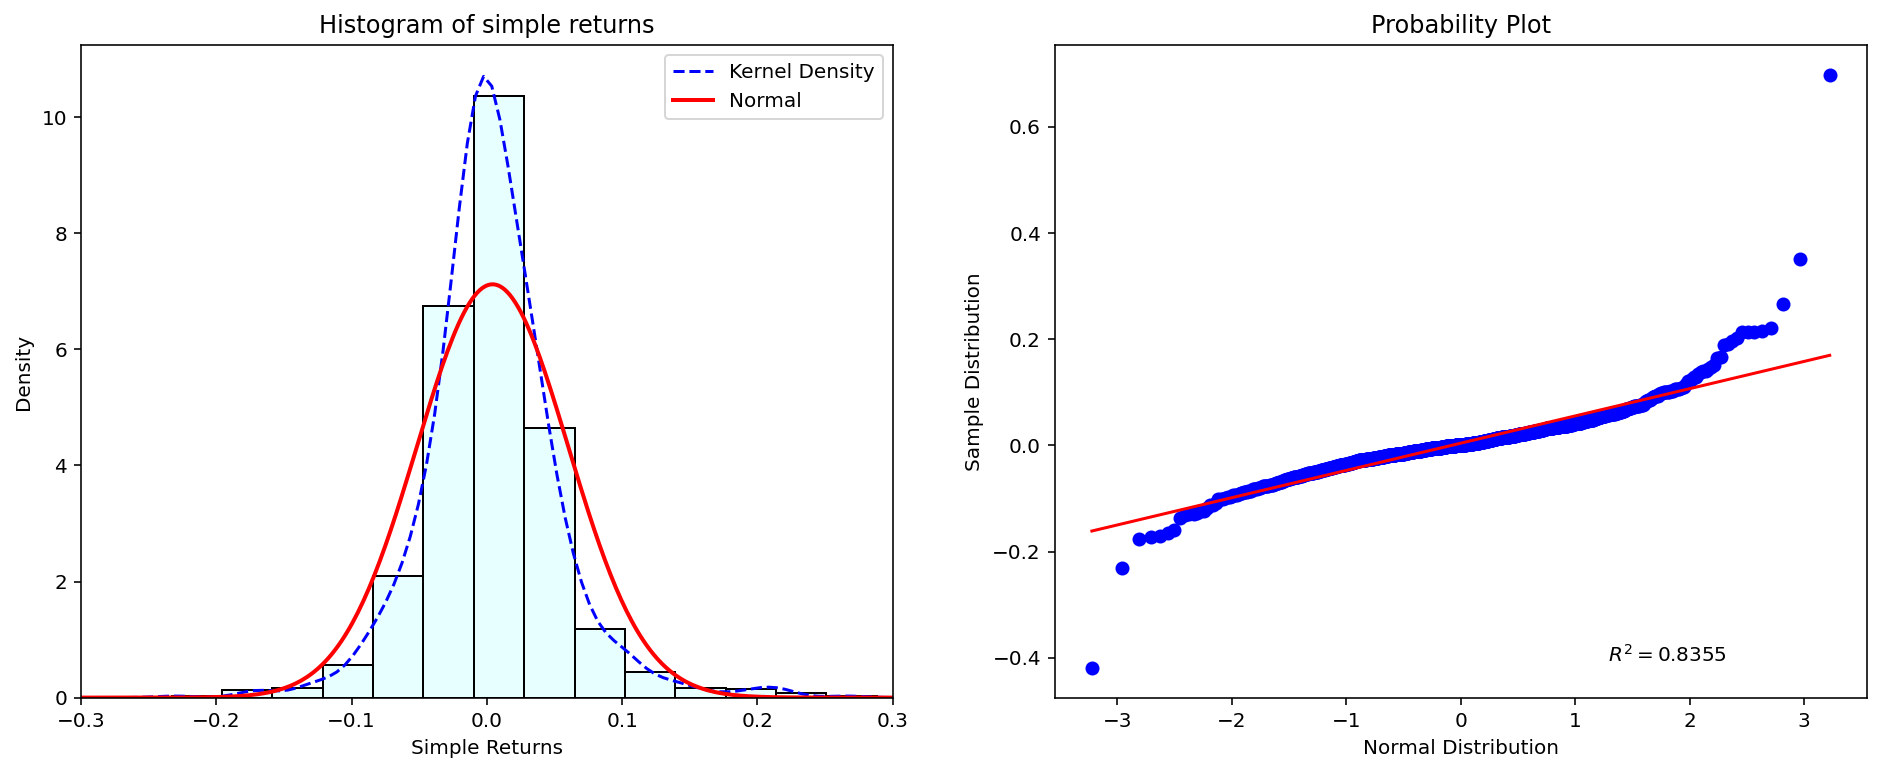

In [16]:
multiPlot(df["BNB-USD"])

In [17]:
print("BNB distribution skewness: " + str(stats.skew(df["BNB-USD"].pct_change().iloc[1:])))
print("BNB distribution kurtosis: " + str(stats.kurtosis(df["BNB-USD"].pct_change().iloc[1:])))

BNB distribution skewness: 1.885692732600203
BNB distribution kurtosis: 26.882181127044785


## Mean-Variance-Optimization (MVO)

MVO is the process of weighing risk, expressed as variance, against expected return. We'll use the package `PyPortfolioOpt` for all our calculations.

### Calculate Annual Mean Return Vector $\mu$

First we need to calculate the annual mean returns for each asset using the geometric mean:
$\bar{r} = [(1+r_{1}) \cdot (1+r_{2}) \cdots (1+r_{n})]^{365/n} - 1$

$$\mu = \begin{pmatrix} \bar{r}_{1} \\ \bar{r}_{2} \\ \bar{r}_{3} \\ \vdots \\ \bar{r}_{n} \\ \end{pmatrix}$$

In [18]:
from pypfopt import expected_returns
mu = expected_returns.mean_historical_return(df, compounding = True, frequency = 365)
print("Vector of mean returns:")
print(mu)

Vector of mean returns:
Symbols
BTC-USD     0.848579
ETH-USD     0.485400
ADA-USD     0.881179
LINK-USD    3.126118
BNB-USD     1.690979
dtype: float64


### Compute Variance-Covariance Matrix $\Sigma$

In addition to the expected returns, MVO requires a risk model, some way of quantifying asset risk. We'll use the classic covariance-matrix first.

Whereas the sample covariance between two assets $x$ and $y$ can be denoted as: $\;\text{Cov}(x,y) = \sigma_{xy} = \frac{1}{N-1}\sum^N_{i=1}(x_{i}-\bar{x})(y_{i}-\bar{y})$, and the basic sample variance of an asset can be expressed as $\sigma^2 = \frac{1}{N-1}\sum^N_{i=1}(x_{i}-\bar{x})^2$.

$$\Sigma = \begin{pmatrix} \sigma^2_{1} & \sigma_{12} & \cdots & \sigma^2_{1n} \\ \sigma_{21} & \sigma^2_{2} & \cdots & \sigma_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{n1} & \sigma_{n2} & \cdots & \sigma^2_{n} \end{pmatrix}$$

In [19]:
from pypfopt.risk_models import sample_cov
sigma = sample_cov(df)
print(sigma)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.356298  0.380016  0.373931  0.338779  0.323393
ETH-USD   0.380016  0.608333  0.561707  0.511164  0.433797
ADA-USD   0.373931  0.561707  0.872840  0.544758  0.460732
LINK-USD  0.338779  0.511164  0.544758  1.207648  0.440891
BNB-USD   0.323393  0.433797  0.460732  0.440891  0.791393


### Efficient Frontier

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return. We can plot the efficient frontier by defining $\mu_{p}=\mu^{T}w$ as the expected return and $\sigma^2_{p}=w^{T}\Sigma w$ as the volatility of the respected portfolio, the weights $w$ are initialized randomly at first.

After visualizing the efficient frontier, we want to find two specific portfolios: the portfolio with the maximum sharpe-ratio and the portfolio with the minimum volatility.

$$\text{Minimum Volatility: } \; \min_{w} \{w^{T}\Sigma w\}$$

$$\text{Maximum Sharpe-Ratio: } \; \max_{w} \left\{ \frac{\mu^{T}w - r_{f}}{w^{T}\Sigma w} \right\}$$

In [20]:
# generate n random portfolios for plotting
n = 20000
w = np.random.dirichlet(np.ones(len(mu)), n) # weights

# compute returns and volatility
returns = w.dot(mu)
variance = np.sqrt(np.diag(w @ sigma @ w.T))

# compute sharpe-ratio
sharpe_ratio = (returns - 0.02) / variance

In [21]:
from matplotlib.gridspec import GridSpec
from pypfopt.efficient_frontier import EfficientFrontier

# tell piecharts to only show weights > 0
def my_autopct(pct):
    return ("%.0f" % pct) if pct > 0 else "" 

# function for plotting the efficient frontier

# set colors for piechart
pie_c = ["orange", "grey", "cyan", "lightblue", "salmon"]

def plotEF(returns, variance, mu, sigma, labels_list):
    max_sharpe = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    max_sharpe.max_sharpe() # maximum sharpe-ratio
    returns_ms, variance_ms, _ = max_sharpe.portfolio_performance()

    min_vola = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
    min_vola.min_volatility() # minimum volatility
    returns_mv, variance_mv, _ = min_vola.portfolio_performance()

    fig = plt.figure(figsize = (18, 8))
    gs = GridSpec(nrows = 2, ncols = 2, wspace = -0.2)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.scatter(variance, returns, marker = ".", c = sharpe_ratio, cmap = "plasma")
    ax0.scatter(variance_ms, returns_ms, marker = ".", s = 700, c = "b", label = "Maximum Sharpe-Ratio")
    ax0.scatter(variance_mv, returns_mv, marker = ".", s = 700, c = "g", label = "Minimum Volatility")
    ax0.set_title("Efficient Frontier")
    ax0.set_xlabel("Volatility")
    ax0.set_ylabel("Returns")
    ax0.legend(frameon = False, borderpad = 1.5, labelspacing = 1)
    
    # plot piechart of portfolio with minimum volatility
    ax1 = fig.add_subplot(gs[0,1])
    ef_mv = EfficientFrontier(mu, sigma)
    weights_mv = ef_mv.min_volatility()
    pd.Series(weights_mv).plot.pie(labels = labels_list, colors = pie_c, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Minimum Volatility Portfolio")

    # plot piechart of portfolio with maximum sharpe-ratio
    ax2 = fig.add_subplot(gs[1,1])
    ef_ms = EfficientFrontier(mu, sigma)
    weights_ms = ef_ms.max_sharpe()
    pd.Series(weights_ms).plot.pie(labels = labels_list, colors = pie_c, autopct = my_autopct)
    plt.ylabel("")
    plt.title("Maximum Sharpe-Ratio Portfolio")

    plt.show()

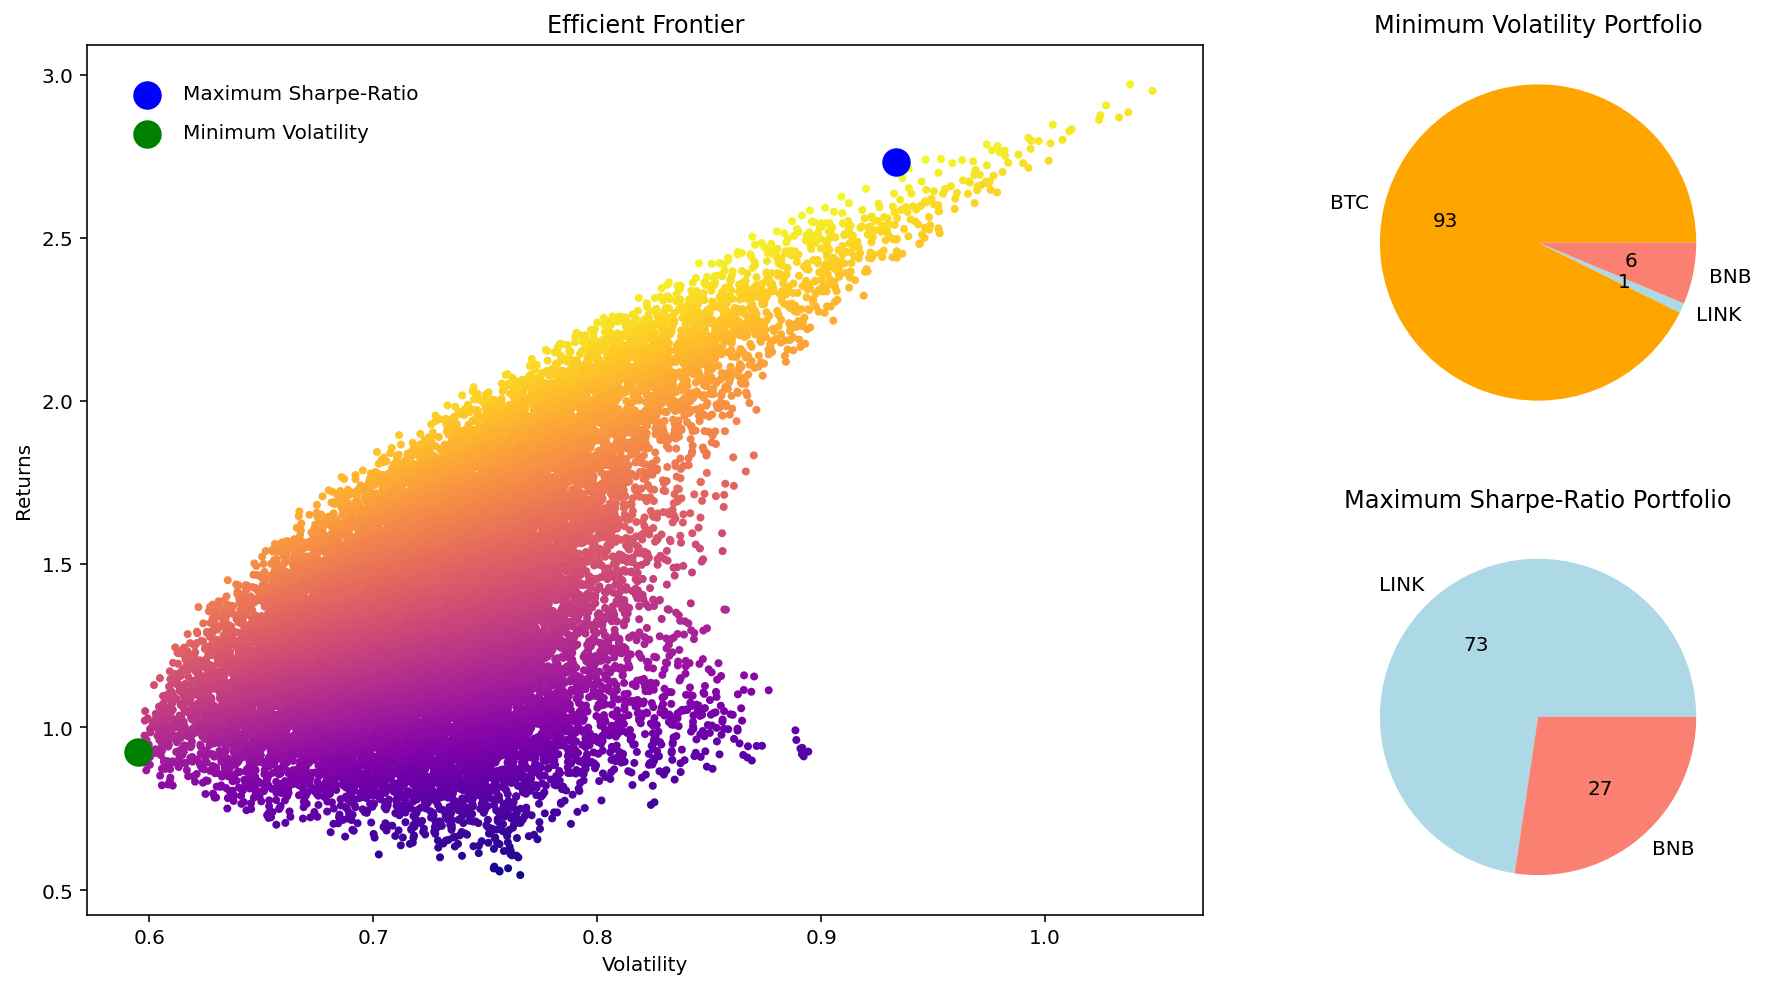

In [22]:
plotEF(returns, variance, mu, sigma, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## MVO + Capital Asset Pricing Model (CAPM)

The CAPM is a model that attempts to describe the relationship between the risk and the expected return of an asset. It is used to determine an investment's appropriate price. The CAPM says that the expected return of a security or a portfolio is equal to the rate on a risk-free security plus a risk premium multiplied by the asset's systematic risk, where the systematic risk is represented by the beta factor $\beta_{i}$. The risk premium can be described as the expected return of the market that is above the risk-free rate $r_{f}$. We'll use the CRIX cryptocurreny index as our market data for the CAPM. The CRIX is realtime computed by the Ladislaus von Bortkiewicz Chair of Statistics at Humboldt University Berlin, Germany.

In [23]:
market_data = pd.read_json("http://data.thecrix.de/data/crix.json")
market_data.set_index("date", inplace = True)
print(market_data)

                    price
date                     
2014-07-31    1000.000000
2014-08-01    1018.202717
2014-08-02    1008.772389
2014-08-03    1004.416500
2014-08-04    1004.984138
...                   ...
2021-03-20  161865.217386
2021-03-21  163019.381706
2021-03-22  160800.249284
2021-03-23  153236.658385
2021-03-24  152579.318986

[2429 rows x 1 columns]


### Distribution of the CRIX

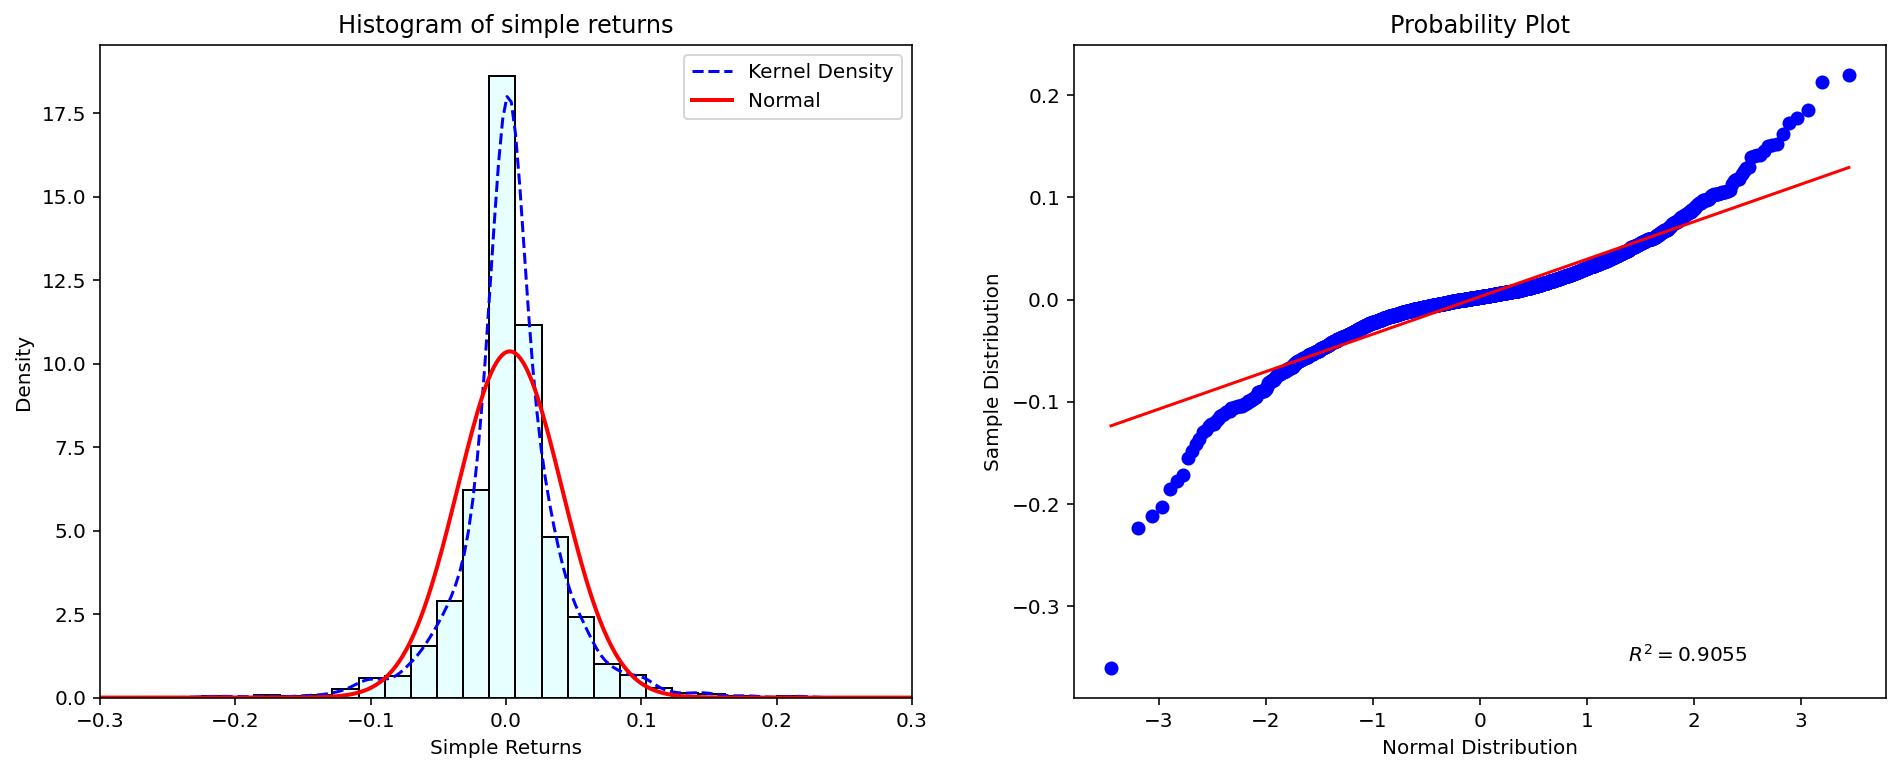

In [24]:
multiPlot(market_data["price"])

In [25]:
print("CRIX distribution skewness: " + str(stats.skew(market_data["price"].pct_change().iloc[1:])))
print("CRIX distribution kurtosis: " + str(stats.kurtosis(market_data["price"].pct_change().iloc[1:])))

CRIX distribution skewness: -0.4032365963920751
CRIX distribution kurtosis: 7.587247101810732


### CAPM using the CRIX

Calculate the expected returns for each asset using the CAPM: $E[r_{i}] = r_{f} + (E[r_{m}]-r_{f})\beta_{i}$

In [26]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365, market_prices = market_data)
print("Expected returns using benchmark data:")
print(mu_capm)

Expected returns using benchmark data:
BTC-USD     0.013202
ETH-USD     0.017445
ADA-USD    -0.020049
LINK-USD   -0.006039
BNB-USD     0.040418
Name: mkt, dtype: float64


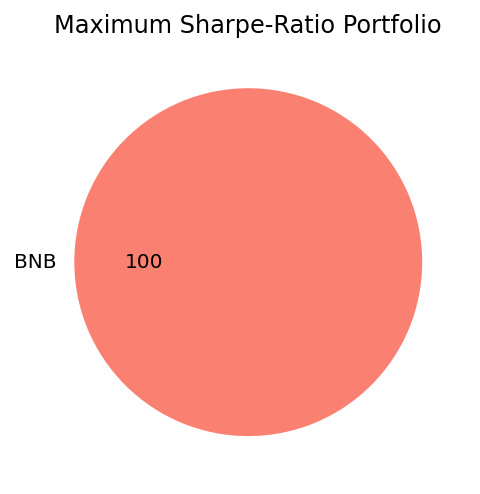

In [27]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], 
                                            colors = pie_c, autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

### CAPM without market data

Not using any market data results in the model using the given returns as a proxy for $E[r_{m}]$.

In [28]:
mu_capm = expected_returns.capm_return(df, compounding = True, frequency = 365)
print("Expected returns not using benchmark:")
print(mu_capm)

Expected returns not using benchmark:
Symbols
BTC-USD     1.185031
ETH-USD     1.660005
ADA-USD     1.869655
LINK-USD    2.020359
BNB-USD     1.630550
Name: mkt, dtype: float64


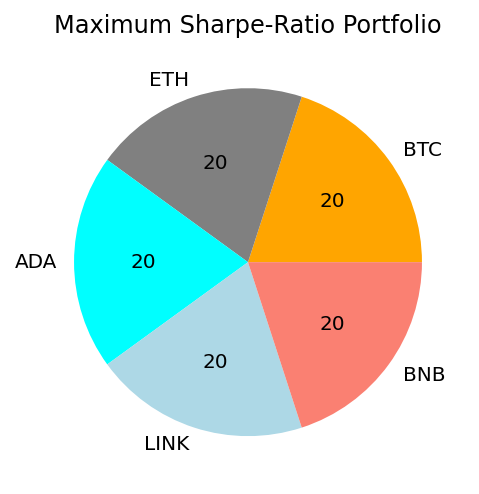

In [29]:
ef_capm = EfficientFrontier(mu_capm, sigma, weight_bounds = (0,1))
weights_capm = ef_capm.max_sharpe()
pd.Series(ef_capm.clean_weights()).plot.pie(labels = ["BTC", "ETH", "ADA", "LINK", "BNB"], 
                                            colors = pie_c, autopct = my_autopct)
plt.ylabel("")
plt.title("Maximum Sharpe-Ratio Portfolio");

## MVO - Using Different Risk Model

The standard approach of quantifying asset risk in MVO consists of just using the sample covariance-matrix like we did above. However, it can be argued that this is carelessly throwing away a good deal of information, because covariance does not preserve the order of observations. In the case of time series, the order of the returns is of fundamental importance, thus we need some way of including the sequential nature of the data into the definition of covariance. This is where the exponentially-weighted covariance-matrix comes into play: rather than letting $(x_{i},y_{i})$ be any observations from the dataset, let us preserve the order by saying that $(x_{i},y_{i})$ denotes the returns of asset $X$ and $Y$ $i$ days ago. Thus $(x_{1}-\bar{x})(y_{1}-\bar{y})$ specifically refers to the co-variation of the returns yesterday. Now we simply give each co-variation term an exponential weight as follows: $\;\text{Cov}(x,y) = \frac{\alpha}{N-1}\sum^N_{i=1}(1-\alpha)^{i-1}(x_{i}-\bar{x})(y_{i}-\bar{y})$, where $\alpha$ represents the decay rate. We can choose high values for $\alpha$, to give more weight to recent results:

$$\alpha = \frac{2}{\text{span}+1}$$

The `span` parameter can be tuned via the `exp_cov` function of `PyPortfolioOpt`.

### Exponentially-Weighted Covariance Matrix

In [30]:
# using the exp_cov function for computation of the weighted matrix
from pypfopt.risk_models import exp_cov
sigma_exp = exp_cov(df, frequency = 365, span = 80) # choose span
print(sigma_exp)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.690786  0.602149  0.450694  0.572943  0.896739
ETH-USD   0.602149  0.976152  0.645414  0.842223  0.836957
ADA-USD   0.450694  0.645414  2.411922  0.849435  0.888416
LINK-USD  0.572943  0.842223  0.849435  1.566559  1.036163
BNB-USD   0.896739  0.836957  0.888416  1.036163  4.521163


In [31]:
variance_exp = np.sqrt(np.diag(w @ sigma_exp @ w.T))
sharpe_ratio = (returns - 0.02) / variance_exp

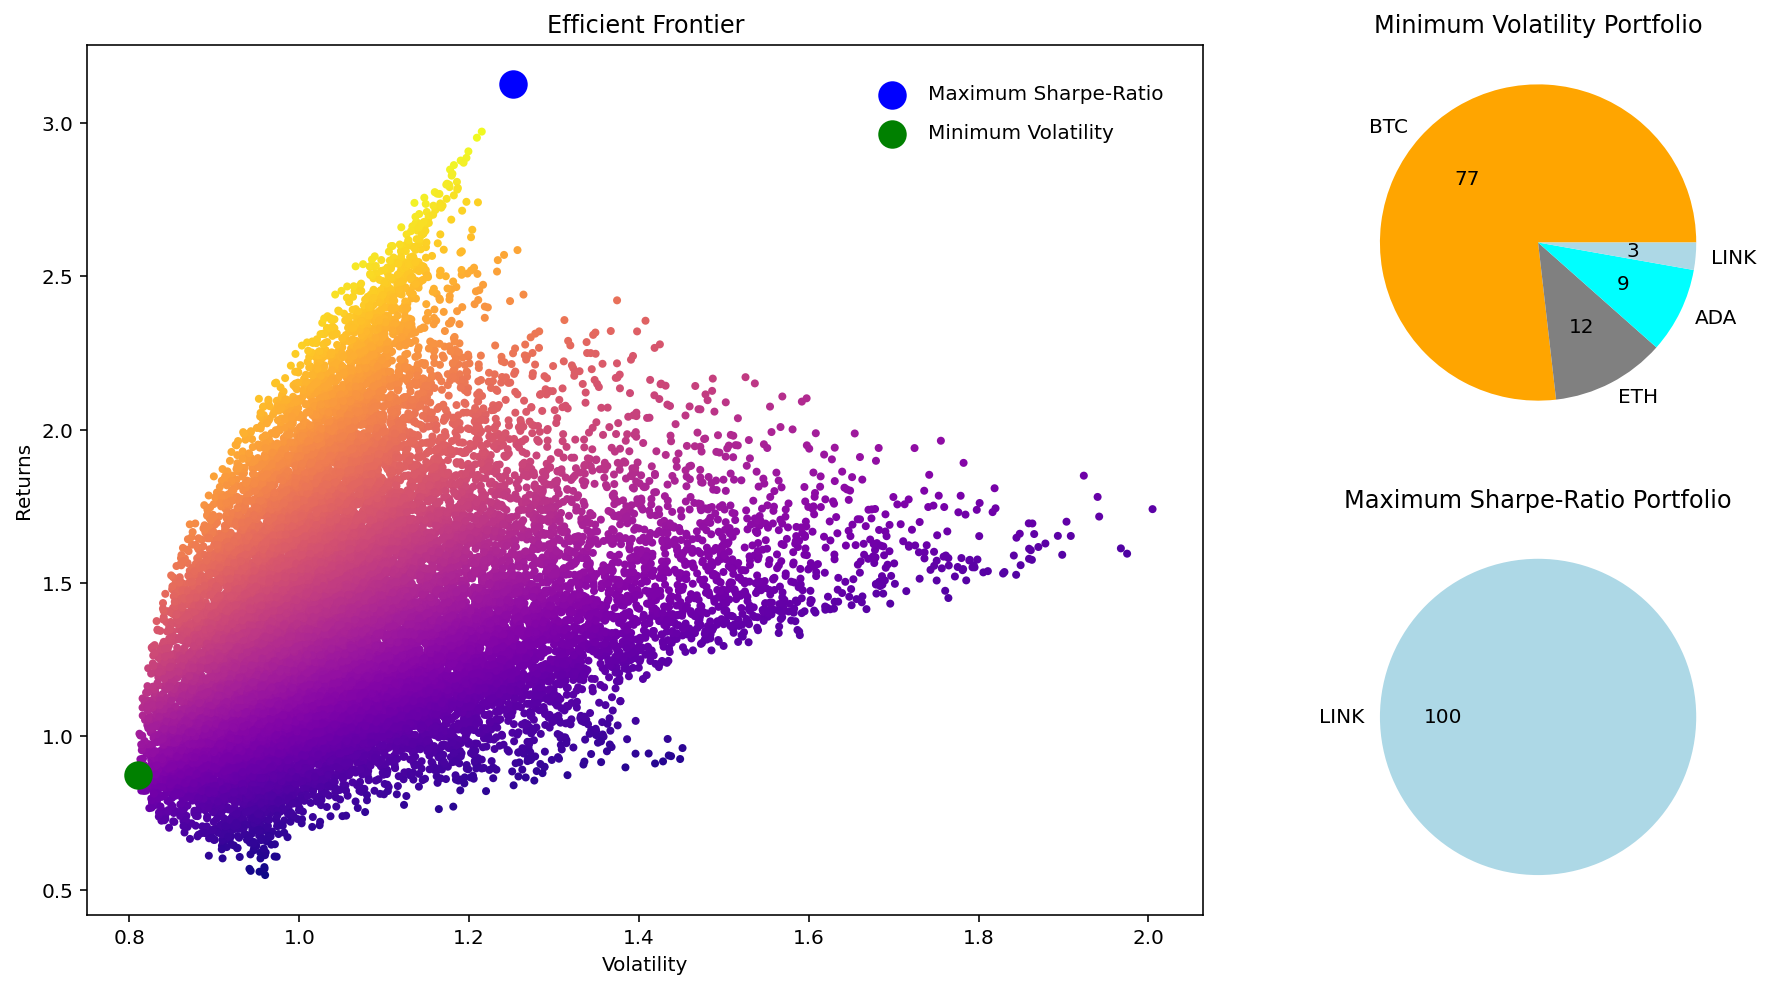

In [32]:
plotEF(returns, variance_exp, mu, sigma_exp, ["BTC", "ETH", "ADA", "LINK", "BNB"])

## Preliminary Conclusion

Despite their strong theoretical foundations, efficient frontier portfolios often have poor real-life performance due to estimation errors in the inputs. These errors mainly come from using mean historical returns as an estimator of future return. The easiest way to avoid this problem is to not provide the expected returns to the optimizer, and just optimize on the sample covariance matrix instead. Effectively we are saying that although previous returns won't predict future returns, previous risks might predict future risks. Empirical results support this, showing that minimum variance portfolios outperform standard MVO. In our case, we should therefore expect that the minimum variance portfolio - using the weighted covariance matrix - has the best performance among all other portfolios tested as of now, in relation to this notebook.

## Black-Litterman Allocation

The Black-Litterman (BL) allocation is a bayesian model which essentially provides a way of combining the investors views on the chosen assets with some prior estimate of returns. The Black-Litterman expected returns are then a bayesian weighted average of the prior and the investors views, with a weighting based on the confidence of each view. To begin with, we need to compute the prior and specify our views on the selected assets. Given the inputs, we can then compute the expected returns:

$$E[r] = [(\tau\Sigma)^{-1} + P^T \Omega^{-1}P]^{-1} [(\tau\Sigma)^{-1} \Pi + P^T \Omega^{-1}Q]$$

Here, $\tau$ is a tuning scalar, $Q$ is the vector of views, $P$ is the picking matrix which maps the views to the assets, $\Omega$ is the uncertainty matrix of views and $\Pi$ is the vector prior returns. $\Sigma$ represents the covariance matrix of asset returns, we'll use the exponentially-weighted covariance matrix in this case. As we know, in addition to the expected returns, MVO requires a risk model. We can calculate a posterior estimate of the covariance matrix using the BL:

$$\hat{\Sigma} = \Sigma + [(\tau\Sigma)^{-1} + P^T \Omega^{-1}P]^{-1}$$

### Constructing the Prior
We can think of the prior as the default estimate, in the absence of any information. The vector of prior returns can be computed by using the following formula:

$$\Pi = \delta \Sigma w_{m}$$

Where $w_{m}$ denotes the market-cap weights and $\delta = \frac{E[r_{m}]-r_{f}}{\sigma_{m}^2}$ represents the market-implied risk premium. We'll use the CRIX index again as our market.

In [33]:
# get market caps
import yfinance as yf

mcaps = {}
for x in data_list:
    stock = yf.Ticker(x)
    mcaps[x] = stock.info["marketCap"]
    
print(mcaps)

{'BTC-USD': 961411809280, 'ETH-USD': 184179195904, 'ADA-USD': 35443638272, 'LINK-USD': 10650451968, 'BNB-USD': 35928395776}


In [56]:
# compute market-implied risk premium and the vector of prior returns
from pypfopt import black_litterman
delta = black_litterman.market_implied_risk_aversion(market_data, frequency = 365).values
pi = black_litterman.market_implied_prior_returns(mcaps, delta, sigma_exp) # use exp weighted risk matrix
print(pi)

Symbols
BTC-USD     1.283675
ETH-USD     1.270400
ADA-USD     1.054048
LINK-USD    1.223709
BNB-USD     1.880857
dtype: float64


### Views & Confidences

Next, we need to specify the vector of views $Q$ and the uncertainty matrix $\Omega$.

In [69]:
q = {
    "BTC-USD" : 0.25,  # BTC will rise by 15%
    "ETH-USD" : 0.20,  # ETH will rise by 10%
    "ADA-USD" : 0.40,  # ADA will rise by 30%
    "LINK-USD" : 0.10, # LINK will rise by 10%
    "BNB-USD" : -0.20  # BNB will drop by 20%
}

In [70]:
confidences = [
    0.8, # confident in BTC
    0.5, # ...
    0.7, # ...
    0.5, # ...
    0.4, # less confident in BNB
]

### Expected Returns & Risk Model

In [75]:
from pypfopt import BlackLittermanModel
bl = BlackLittermanModel(sigma_exp, pi = pi, market_caps = mcaps, risk_aversion = delta, 
                         absolute_views = q, omega = "idzorek", view_confidences = confidences)

# expected returns
returns_bl = bl.bl_returns()
print(returns_bl)

Symbols
BTC-USD     0.406346
ETH-USD     0.380614
ADA-USD     0.384180
LINK-USD    0.285005
BNB-USD     0.403232
dtype: float64


In [74]:
# covariance matrix
sigma_bl = bl.bl_cov()
print(sigma_bl)

Symbols    BTC-USD   ETH-USD   ADA-USD  LINK-USD   BNB-USD
Symbols                                                   
BTC-USD   0.696954  0.605367  0.451470  0.574959  0.901569
ETH-USD   0.605367  0.991896  0.648112  0.849843  0.839523
ADA-USD   0.451470  0.648112  2.446095  0.853917  0.891864
LINK-USD  0.574959  0.849843  0.853917  1.596746  1.042756
BNB-USD   0.901569  0.839523  0.891864  1.042756  4.636035


### Portfolios

In [81]:
# maximum sharpe-ratio
ef_bl = EfficientFrontier(returns_bl, sigma_bl)
ef_bl.max_sharpe()
weights = ef_bl.clean_weights()
print(weights)

OrderedDict([('BTC-USD', 0.86764), ('ETH-USD', 0.04587), ('ADA-USD', 0.08648), ('LINK-USD', 0.0), ('BNB-USD', 0.0)])


In [82]:
# minimum volatility
ef_bl = EfficientFrontier(returns_bl, sigma_bl)
ef_bl.min_volatility()
weights = ef_bl.clean_weights()
print(weights)

OrderedDict([('BTC-USD', 0.76677), ('ETH-USD', 0.11629), ('ADA-USD', 0.0878), ('LINK-USD', 0.02914), ('BNB-USD', 0.0)])
